In [ ]:
import torch
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
transform = transforms.Compose(
    [transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [ ]:
batch_size = 128

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

100%|██████████| 170498071/170498071 [00:02<00:00, 78641560.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# выводим информацию о датасете
print("Размер тренировочного датасета: ", len(train_dataset))
print("Размер тестового датасета: ", len(test_dataset))
print("Размер батча: ", batch_size)

# определяем количество классов
num_classes = len(train_dataset.classes)
print("Количество классов: ", num_classes)

# определяем диапазон значений пикселей
pixel_min = train_dataset.data.min()
pixel_max = train_dataset.data.max()
print("Минимальное значение пикселя: ", pixel_min)
print("Максимальное значение пикселя: ", pixel_max)

# определяем тип данных пикселей
pixel_type = train_dataset.data.dtype
print("Тип данных пикселей: ", pixel_type)

Размер тренировочного датасета:  50000
Размер тестового датасета:  10000
Размер батча:  128
Количество классов:  10
Минимальное значение пикселя:  0
Максимальное значение пикселя:  255
Тип данных пикселей:  uint8


In [ ]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

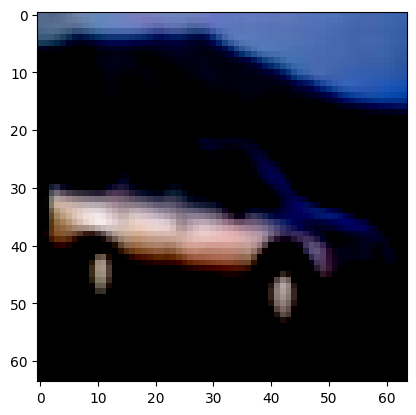

In [ ]:
image, label = train_dataset[4]

plt.imshow(image.permute(1, 2, 0))
plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.fc1 = nn.Linear(8*8*128, 500)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 8*8*128)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [ ]:
net = Net().cuda()

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

In [ ]:
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = loss_function(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs = test_inputs.cuda()
      test_labels = test_labels.cuda()
      test_outputs = net(test_inputs)
      test_loss = loss_function(test_outputs, test_labels)

      _, test_preds = torch.max(test_outputs, 1)
      test_running_loss += test_loss.item()
      test_running_corrects += torch.sum(test_preds == test_labels.data)

  epoch_loss = running_loss/(len(train_loader)*batch_size)
  epoch_acc = running_corrects.float()/(len(train_loader)*batch_size)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc.cpu().numpy())

  test_epoch_loss = test_running_loss/(len(test_loader)*batch_size)
  test_epoch_acc = test_running_corrects.float()/(len(test_loader)*batch_size)
  test_running_loss_history.append(test_epoch_loss)
  test_running_corrects_history.append(test_epoch_acc.cpu().numpy())

  print('epoch: ', e+1)
  print('training_loss: {:.4f}, acc: {:.4f} '.format(epoch_loss, epoch_acc.item()))
  print('test_loss: {:.4f}, test_acc: {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))

epoch:  1
training_loss: 0.0134, acc: 0.3869 
test_loss: 0.0116, test_acc: 0.4589 
epoch:  2
training_loss: 0.0109, acc: 0.5020 
test_loss: 0.0103, test_acc: 0.5252 
epoch:  3
training_loss: 0.0099, acc: 0.5484 
test_loss: 0.0096, test_acc: 0.5491 
epoch:  4
training_loss: 0.0092, acc: 0.5799 
test_loss: 0.0092, test_acc: 0.5772 
epoch:  5
training_loss: 0.0086, acc: 0.6104 
test_loss: 0.0086, test_acc: 0.6030 
epoch:  6
training_loss: 0.0081, acc: 0.6339 
test_loss: 0.0084, test_acc: 0.6176 
epoch:  7
training_loss: 0.0076, acc: 0.6569 
test_loss: 0.0080, test_acc: 0.6322 
epoch:  8
training_loss: 0.0072, acc: 0.6774 
test_loss: 0.0078, test_acc: 0.6391 
epoch:  9
training_loss: 0.0068, acc: 0.6967 
test_loss: 0.0075, test_acc: 0.6509 
epoch:  10
training_loss: 0.0064, acc: 0.7136 
test_loss: 0.0075, test_acc: 0.6506 
epoch:  11
training_loss: 0.0061, acc: 0.7291 
test_loss: 0.0072, test_acc: 0.6652 
epoch:  12
training_loss: 0.0057, acc: 0.7439 
test_loss: 0.0071, test_acc: 0.6707 
e

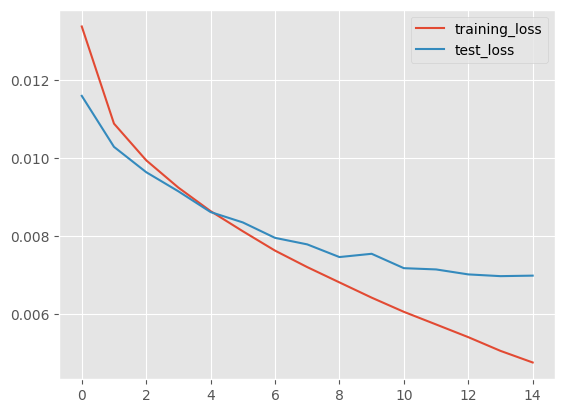

In [ ]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label = 'training_loss')
plt.plot(test_running_loss_history, label = 'test_loss')
plt.legend()

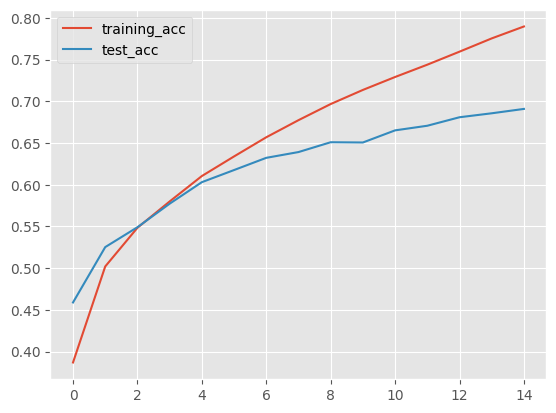

In [ ]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training_acc')
plt.plot(test_running_corrects_history, label='test_acc')
plt.legend()

In [ ]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1 

for i in range(10):
  print("Accurace of %5s : %2d %%" % (classes[i], 100*class_correct[i]/class_total[i]))

print()

Accurace of airplane : 75 %
Accurace of automobile : 77 %
Accurace of  bird : 60 %
Accurace of   cat : 52 %
Accurace of  deer : 50 %
Accurace of   dog : 54 %
Accurace of  frog : 73 %
Accurace of horse : 77 %
Accurace of  ship : 76 %
Accurace of truck : 80 %



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.fc1 = nn.Linear(8*8*128, 500)
        self.fc2 = nn.Linear(500, 256) # Добавлен полносвязный слой fc2
        self.dropout1 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 10) # Добавлен полносвязный слой fc3
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = x.view(-1, 8*8*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) # Добавлен полносвязный слой fc2
        x = self.dropout1(x)
        x = self.fc3(x) # Добавлен полносвязный слой fc3
        return F.log_softmax(x, dim=1)

In [ ]:
net = Net().cuda()

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

In [ ]:
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = loss_function(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs = test_inputs.cuda()
      test_labels = test_labels.cuda()
      test_outputs = net(test_inputs)
      test_loss = loss_function(test_outputs, test_labels)

      _, test_preds = torch.max(test_outputs, 1)
      test_running_loss += test_loss.item()
      test_running_corrects += torch.sum(test_preds == test_labels.data)

  epoch_loss = running_loss/(len(train_loader)*batch_size)
  epoch_acc = running_corrects.float()/(len(train_loader)*batch_size)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc.cpu().numpy())

  test_epoch_loss = test_running_loss/(len(test_loader)*batch_size)
  test_epoch_acc = test_running_corrects.float()/(len(test_loader)*batch_size)
  test_running_loss_history.append(test_epoch_loss)
  test_running_corrects_history.append(test_epoch_acc.cpu().numpy())

  print('epoch: ', e+1)
  print('training_loss: {:.4f}, acc: {:.4f} '.format(epoch_loss, epoch_acc.item()))
  print('test_loss: {:.4f}, test_acc: {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))

epoch:  1
training_loss: 0.0146, acc: 0.3214 
test_loss: 0.0126, test_acc: 0.4064 
epoch:  2
training_loss: 0.0120, acc: 0.4376 
test_loss: 0.0114, test_acc: 0.4657 
epoch:  3
training_loss: 0.0111, acc: 0.4832 
test_loss: 0.0107, test_acc: 0.5009 
epoch:  4
training_loss: 0.0105, acc: 0.5109 
test_loss: 0.0103, test_acc: 0.5197 
epoch:  5
training_loss: 0.0101, acc: 0.5361 
test_loss: 0.0098, test_acc: 0.5456 
epoch:  6
training_loss: 0.0096, acc: 0.5566 
test_loss: 0.0096, test_acc: 0.5547 
epoch:  7
training_loss: 0.0092, acc: 0.5774 
test_loss: 0.0092, test_acc: 0.5711 
epoch:  8
training_loss: 0.0088, acc: 0.5986 
test_loss: 0.0090, test_acc: 0.5829 
epoch:  9
training_loss: 0.0084, acc: 0.6144 
test_loss: 0.0087, test_acc: 0.5976 
epoch:  10
training_loss: 0.0080, acc: 0.6360 
test_loss: 0.0083, test_acc: 0.6135 
epoch:  11
training_loss: 0.0077, acc: 0.6535 
test_loss: 0.0081, test_acc: 0.6215 
epoch:  12
training_loss: 0.0073, acc: 0.6684 
test_loss: 0.0078, test_acc: 0.6391 
e

In [ ]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label = 'training_loss')
plt.plot(test_running_loss_history, label = 'test_loss')
plt.legend()

NameError: ignored

In [ ]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training_acc')
plt.plot(test_running_corrects_history, label='test_acc')
plt.legend()

In [ ]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1 

for i in range(10):
  print("Accurace of %5s : %2d %%" % (classes[i], 100*class_correct[i]/class_total[i]))

print()

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc_layers = nn.Sequential(
        nn.Linear(8*8*32, 2048),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(2048, 2048),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(2048, 10)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(-1, 8*8*32)
    x = self.fc_layers(x)
    return x

In [ ]:
net = Net().cuda()

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

In [ ]:
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = loss_function(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs = test_inputs.cuda()
      test_labels = test_labels.cuda()
      test_outputs = net(test_inputs)
      test_loss = loss_function(test_outputs, test_labels)

      _, test_preds = torch.max(test_outputs, 1)
      test_running_loss += test_loss.item()
      test_running_corrects += torch.sum(test_preds == test_labels.data)

  epoch_loss = running_loss/(len(train_loader)*batch_size)
  epoch_acc = running_corrects.float()/(len(train_loader)*batch_size)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc.cpu().numpy())

  test_epoch_loss = test_running_loss/(len(test_loader)*batch_size)
  test_epoch_acc = test_running_corrects.float()/(len(test_loader)*batch_size)
  test_running_loss_history.append(test_epoch_loss)
  test_running_corrects_history.append(test_epoch_acc.cpu().numpy())

  print('epoch: ', e+1)
  print('training_loss: {:.4f}, acc: {:.4f} '.format(epoch_loss, epoch_acc.item()))
  print('test_loss: {:.4f}, test_acc: {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))

epoch:  1
training_loss: 0.0105, acc: 0.5056 
test_loss: 0.0080, test_acc: 0.6299 
epoch:  2
training_loss: 0.0063, acc: 0.7155 
test_loss: 0.0056, test_acc: 0.7424 
epoch:  3
training_loss: 0.0046, acc: 0.7989 
test_loss: 0.0051, test_acc: 0.7781 
epoch:  4
training_loss: 0.0035, acc: 0.8484 
test_loss: 0.0047, test_acc: 0.7926 
epoch:  5
training_loss: 0.0028, acc: 0.8799 
test_loss: 0.0043, test_acc: 0.8155 
epoch:  6
training_loss: 0.0021, acc: 0.9075 
test_loss: 0.0043, test_acc: 0.8246 
epoch:  7
training_loss: 0.0017, acc: 0.9260 
test_loss: 0.0045, test_acc: 0.8225 
epoch:  8
training_loss: 0.0013, acc: 0.9408 
test_loss: 0.0044, test_acc: 0.8313 
epoch:  9
training_loss: 0.0011, acc: 0.9532 
test_loss: 0.0047, test_acc: 0.8340 
epoch:  10
training_loss: 0.0009, acc: 0.9602 
test_loss: 0.0045, test_acc: 0.8420 
epoch:  11
training_loss: 0.0008, acc: 0.9674 
test_loss: 0.0051, test_acc: 0.8351 
epoch:  12
training_loss: 0.0006, acc: 0.9710 
test_loss: 0.0052, test_acc: 0.8355 
e

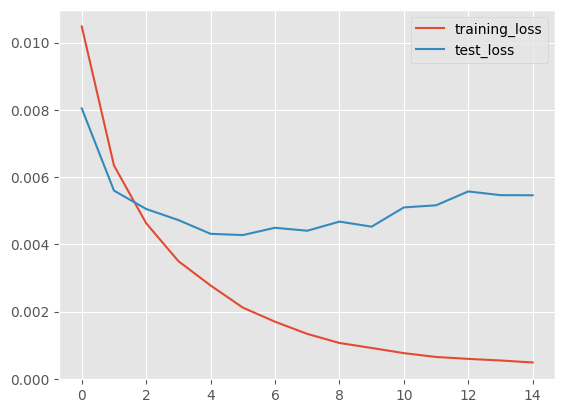

In [ ]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label = 'training_loss')
plt.plot(test_running_loss_history, label = 'test_loss')
plt.legend()

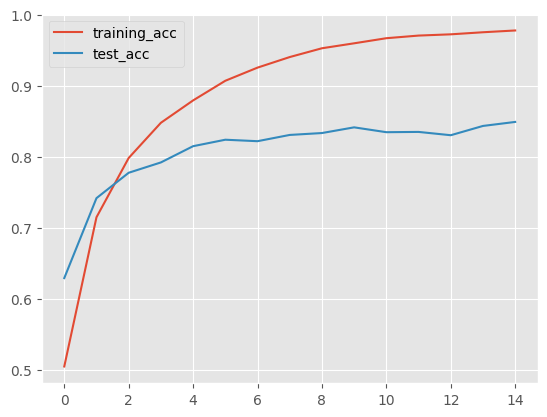

In [ ]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training_acc')
plt.plot(test_running_corrects_history, label='test_acc')
plt.legend()

In [ ]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1 

for i in range(10):
  print("Accurace of %5s : %2d %%" % (classes[i], 100*class_correct[i]/class_total[i]))

print()

Accurace of airplane : 85 %
Accurace of automobile : 97 %
Accurace of  bird : 88 %
Accurace of   cat : 84 %
Accurace of  deer : 82 %
Accurace of   dog : 75 %
Accurace of  frog : 93 %
Accurace of horse : 84 %
Accurace of  ship : 97 %
Accurace of truck : 90 %

